In [2]:
from pyfaidx import Fasta
import pandas as pd
import numpy as np
from collections import Counter
from pathlib import Path
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import scipy.sparse as sp

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from spektral.data import Dataset, DisjointLoader, Graph
from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv
from spektral.models.gcn import GCN
from spektral.models.gnn_explainer import GNNExplainer
from spektral.transforms import LayerPreprocess
from spektral.transforms.normalize_adj import NormalizeAdj
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.regularizers import l2

from spektral.layers import GCNConv, GlobalSumPool

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

2022-04-14 12:19:33.465988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/pe/lib64:/opt/cray/lib64:/opt/cray/pe/lib64:/opt/cray/lib64:/cm/shared/apps/slurm/20.02.7/lib64/slurm:/cm/shared/apps/slurm/20.02.7/lib64
2022-04-14 12:19:33.466024: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
s = pd.read_csv("S_AUREUS/1280.protein.links.full.v11.5.txt", sep=' ')
s

,protein1,protein2,neighborhood,neighborhood_transferred,fusion,cooccurence,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,1280.SAXN108_0001,1280.SAXN108_1258,0,0,0,280,0,0,0,0,119,0,0,0,202,449
1,1280.SAXN108_0001,1280.SAXN108_2805,0,0,0,0,0,0,0,0,165,0,0,0,72,191
2,1280.SAXN108_0001,1280.SAXN108_0727,0,0,0,0,0,0,70,0,127,0,0,0,94,200
3,1280.SAXN108_0001,1280.SAXN108_1756,0,93,0,150,0,0,0,0,0,0,0,0,52,205
4,1280.SAXN108_0001,1280.SAXN108_0046,0,0,0,159,0,0,132,0,0,0,0,0,136,314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569867,1280.SAXN108_2992,1280.SAXN108_0017,0,0,0,0,0,0,259,0,876,0,0,196,216,934
569868,1280.SAXN108_2992,1280.SAXN108_0018,0,0,0,0,0,0,0,0,0,0,0,0,155,154
569869,1280.SAXN108_2992,1280.SAXN108_2527,0,0,0,0,0,0,0,0,0,0,0,0,197,197
569870,1280.SAXN108_2992,1280.SAXN108_0606,0,0,0,0,0,0,312,0,0,0,0,0,0,311


In [10]:
s['cooccurence'].value_counts()

0      329366
150      5638
151      5522
152      5254
153      5144
        ...  
672        26
650        26
739        24
658        22
682        22
Name: cooccurence, Length: 637, dtype: int64

In [2]:
card_seq = Path("CARD/protein_fasta_protein_homolog_model.fasta")
card_seq_new = Path("card.fasta")
card_label = pd.read_csv("CARD/aro_index.tsv", sep='\t')
# some duplicate ARO in aro_index!
card_label = card_label.drop_duplicates(subset='ARO Accession', keep="first")
card_label.index = card_label['ARO Accession']
card_label = card_label[['Drug Class']]

accessions = []
gene_names = []
sequences = []
if not card_seq_new.exists():
    #>gb|ACT97415.1|ARO:3002999|CblA-1 [mixed culture bacterium AX_gF3SD01_15] 
    with open(card_seq_new, "w") as file:
        for seq in Fasta(str(card_seq)):
            _,_,a,g=seq.long_name.split("|")
            g = g.split()[0]
            accessions.append(a)
            gene_names.append(g)
            sequences.append(str(seq))
            file.write(f">{a} {g}\n")
            file.write(f"{seq}\n")
    
else:
    #>ARO:3002999 CblA-1
    for seq in Fasta(str(card_seq_new)):
        a,g=seq.long_name.split()
        accessions.append(a)
        gene_names.append(g)
        sequences.append(str(seq))
card_seq = pd.DataFrame({"ARO Accession":accessions,
                         "Gene":gene_names,
                         "Sequence":sequences})

In [3]:
card_label.head()

,Drug Class
ARO Accession,
ARO:3005099,lincosamide antibiotic;macrolide antibiotic;st...
ARO:3000317,aminoglycoside antibiotic
ARO:3002523,aminoglycoside antibiotic
ARO:3002524,aminoglycoside antibiotic
ARO:3002525,aminoglycoside antibiotic


In [4]:
card_seq.head()

,ARO Accession,Gene,Sequence
0,ARO:3002999,CblA-1,MKAYFIAILTLFTCIATVVRAQQMSELENRIDSLLNGKKATVGIAV...
1,ARO:3001109,SHV-52,MRYIRLCIISLLAALPLAVHASPQPLEQIKQSESQLSGRVGMIEMD...
2,ARO:3002867,dfrF,MIGLIVARSKNNVIGKNGNIPWKIKGEQKQFRELTTGNVVIMGRKS...
3,ARO:3001989,CTX-M-130,MVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGG...
4,ARO:3002356,NDM-6,MELPNIMHPVAKLSTALAAALMLSGCMPGEIRPTIGQQMETGDQRF...


In [5]:
from collections import Counter
drug_split = card_label['Drug Class'].str.replace(" antibiotic","").str.strip()
drug_split = ";".join(drug_split).split(";")
drug_split = "-".join(drug_split).split("-")
drug_split = Counter(drug_split)
drug_split= {k:v for k,v in drug_split.items() if v>50}
drug_split = dict(sorted(drug_split.items(), key=lambda item: item[1], reverse=True))
print(len(drug_split))
drug_labels = drug_split.keys()
drug_split

21


{'cephalosporin': 3169,
 'carbapenem': 2366,
 'penam': 2239,
 'monobactam': 923,
 'cephamycin': 583,
 'penem': 464,
 'aminoglycoside': 300,
 'fluoroquinolone': 291,
 'tetracycline': 262,
 'macrolide': 237,
 'phenicol': 202,
 'peptide': 180,
 'glycopeptide': 165,
 'lincosamide': 149,
 'streptogramin': 136,
 'glycylcycline': 87,
 'diaminopyrimidine': 87,
 'disinfecting agents and antiseptics': 84,
 'pleuromutilin': 77,
 'nucleoside': 62,
 'rifamycin': 61}

In [6]:
# string_seq = Path("STRING/protein.sequences.v11.5.fa")
# string_adj = pd.read_csv("STRING/protein.physical.links.v11.5.txt", sep='\t')
# string_label = pd.read_csv("STRING/protein.info.v11.5.txt",sep='\t')

In [7]:
string_seq = Path("S_AUREUS/1280.protein.sequences.v11.5.fa")
string_adj = pd.read_csv("S_AUREUS/1280.protein.physical.links.v11.5.txt", sep=' ')
string_label = pd.read_csv("S_AUREUS/1280.protein.info.v11.5.txt",sep='\t')

In [8]:
string_label.head()

,#string_protein_id,preferred_name,protein_size,annotation
0,1280.SAXN108_0001,dnaA,273,Plays an important role in the initiation and ...
1,1280.SAXN108_0002,AID38443.1,182,annotation not available
2,1280.SAXN108_0003,SAXN108_0003,377,Confers DNA tethering and processivity to DNA ...
3,1280.SAXN108_0004,AID38445.1,78,annotation not available
4,1280.SAXN108_0005,recF,370,The RecF protein is involved in DNA metabolism...


In [9]:
string_adj.head()

,protein1,protein2,combined_score
0,1280.SAXN108_0001,1280.SAXN108_0331,251
1,1280.SAXN108_0001,1280.SAXN108_2087,178
2,1280.SAXN108_0001,1280.SAXN108_1710,493
3,1280.SAXN108_0001,1280.SAXN108_0134,218
4,1280.SAXN108_0001,1280.SAXN108_0410,398


In [10]:
accessions = []
sequences = []
for seq in Fasta(str(string_seq)):
        accessions.append(seq.name)
        sequences.append(str(seq))
string_seq = pd.DataFrame({"Accession":accessions,
                         "Sequence":sequences})
string_seq.index = string_seq['Accession']
string_seq = string_seq.drop(['Accession'], axis=1)
string_seq.head()

,Sequence
Accession,
1280.SAXN108_0001,MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSSI...
1280.SAXN108_0002,MGLIVDITPPDYETRMAILQKKIEEEKLDIPPEALNYIANQIQSNI...
1280.SAXN108_0003,MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVILT...
1280.SAXN108_0004,MVQEVVVEGDINLGQFLKTEGIIESGGQAKWFLQDVEVLINGVRET...
1280.SAXN108_0005,MKLNTLQLENYRNYDEVTLKCHPDVNILIGENAQGKTNLLESIYTL...


In [11]:
# makeblastdb -in card.fasta -parse_seqids -blastdb_version 5  -title "CARD" -dbtype prot -out blastdb/card
# blastp -query S_AUREUS/1280.protein.sequences.v11.5.fa -db blastdb/card -out S_AUREUS/1280.protein.sequences.v11.5.tsv -outfmt "6 qseqid sseqid pident evalue bitscore"

In [12]:
aligned = pd.read_csv("S_AUREUS/1280.protein.sequences.v11.5.tsv",sep='\t',names = ['qseqid', 'sseqid', 'pident', 'evalue', 'bitscore'])
aligned['Drug'] = aligned['sseqid'].apply(lambda x: card_label.loc[x]['Drug Class'])
print(len(aligned))
aligned.head()

37706


,qseqid,sseqid,pident,evalue,bitscore,Drug
0,1280.SAXN108_0001,ARO:3000251,36.364,2.10,26.9,lincosamide antibiotic;macrolide antibiotic;ox...
1,1280.SAXN108_0001,ARO:3004730,23.741,3.00,26.2,lincosamide antibiotic;macrolide antibiotic;ox...
2,1280.SAXN108_0002,ARO:3005087,32.558,0.53,27.7,lincosamide antibiotic;macrolide antibiotic;ox...
3,1280.SAXN108_0002,ARO:3000491,27.273,1.50,26.6,aminoglycoside antibiotic
4,1280.SAXN108_0002,ARO:3003682,30.952,2.50,25.8,disinfecting agents and antiseptics


In [13]:
highly_confident_ARG = aligned[aligned['pident']>50]
highly_confident_ARG = highly_confident_ARG.groupby(['qseqid']).agg({'Drug': ';'.join})
highly_confident_ARG['Labels'] = highly_confident_ARG['Drug'].apply(lambda x: [int(i in x) for i in drug_labels])
highly_confident_ARG = highly_confident_ARG.drop(["Drug"],axis=1)
graph_label = {i:row['Labels'] for i, row in highly_confident_ARG.iterrows()}
graph_label

{'1280.SAXN108_0005': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0],
 '1280.SAXN108_0045': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1280.SAXN108_0046': [1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1280.SAXN108_0047': [1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1280.SAXN108_0048': [1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1280.SAXN108_0049': [1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1280.SAXN108_0051': [1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1280.SAXN108_0084': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,


In [14]:
nodes = pd.concat([string_adj['protein1'],string_adj['protein2']]).unique()
print(len(nodes))
nodes

1832


array(['1280.SAXN108_0001', '1280.SAXN108_0002', '1280.SAXN108_0003', ...,
       '1280.SAXN108_2990', '1280.SAXN108_2991', '1280.SAXN108_2992'],
      dtype=object)

In [15]:
np.savetxt('nodes.txt', nodes, fmt='%s')

In [16]:
graph_node_features = []
aligned_node = aligned['qseqid'].unique()
for n in nodes:
    if n in aligned_node:
        temp = aligned[aligned['qseqid']==n]
        drug_labels_score = [0]*len(drug_labels)
        for _, r in temp.iterrows():
            for i, d in enumerate(drug_labels):
                if d in r['Drug']:
                    drug_labels_score[i] += r['bitscore']
        drug_features = np.log(np.array(drug_labels_score)) / np.log(100)
        drug_features = np.clip(drug_features,0.0,1.0)
    else:
        drug_features = [0]*21
    aa_composition = np.array(list(ProteinAnalysis(string_seq.loc[n].values[0]).get_amino_acids_percent().values()))
    features = np.concatenate((drug_features, aa_composition))
    graph_node_features.append(list(features))
graph_node_features = np.array(graph_node_features)
graph_node_features

/localscratch/ipykernel_129320/4109401430.py:11: RuntimeWarning: divide by zero encountered in log
  drug_features = np.log(np.array(drug_labels_score)) / np.log(100)


array([[0.        , 0.        , 0.        , ..., 0.05494505, 0.01098901,
        0.03663004],
       [0.70241686, 0.70241686, 0.70241686, ..., 0.03296703, 0.        ,
        0.03846154],
       [0.        , 0.        , 0.        , ..., 0.07692308, 0.00265252,
        0.01856764],
       ...,
       [1.        , 1.        , 0.        , ..., 0.08061002, 0.00217865,
        0.01960784],
       [0.68180599, 0.68180599, 0.68180599, ..., 0.07692308, 0.        ,
        0.02564103],
       [0.        , 0.        , 0.        , ..., 0.08888889, 0.        ,
        0.02222222]])

In [17]:
adj = np.array([[0]*len(nodes) for _ in range(len(nodes))])
for i, row in string_adj.iterrows():
    source = np.where(nodes == row['protein1'])[0][0]
    target = np.where(nodes == row['protein2'])[0][0]
    score = row['combined_score']
    adj[source,target]=score
adj = sp.csr_matrix(adj)
adj

<1832x1832 sparse matrix of type '<class 'numpy.int64'>'
	with 43338 stored elements in Compressed Sparse Row format>

In [90]:
len(graph_label)

291

In [18]:
labels = []
for n in nodes:
    if n in graph_label.keys():
        labels.append(graph_label[n])
    else:
        labels.append([0]*21)
labels = np.array(labels)
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
Graph(a=adj, x=graph_node_features, y=labels)

Graph(n_nodes=1832, n_node_features=41, n_edge_features=None, n_labels=21)

In [20]:
class MyDataset(Dataset):
    def read(self):
        return [Graph(a=adj, x=graph_node_features, y=labels)]
dataset=MyDataset()
dataset[0]

Graph(n_nodes=1832, n_node_features=41, n_edge_features=None, n_labels=21)

In [21]:
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.5)
        self.dense = Dense(n_labels, 'softmax')

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out

In [22]:
model = MyFirstGNN(32, dataset.n_labels)
model.compile('adam', 'categorical_crossentropy')

2022-04-13 09:16:16.004137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/pe/lib64:/opt/cray/lib64:/opt/cray/pe/lib64:/opt/cray/lib64:/cm/shared/apps/slurm/20.02.7/lib64/slurm:/cm/shared/apps/slurm/20.02.7/lib64
2022-04-13 09:16:16.004184: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-13 09:16:16.004271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tinkercliffs1): /proc/driver/nvidia/version does not exist
2022-04-13 09:16:16.004652: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations,

In [23]:
learning_rate = 1e-2
seed = 0
epochs = 200
patience = 10

from sklearn.model_selection import train_test_split

mask_tr, mask_va = train_test_split(list(range(dataset.n_nodes)), test_size=0.3)
mask_va, mask_te = train_test_split(mask_va, test_size=0.3)
dataset.mask_tr = np.array([True if i in mask_tr else False for i in range(dataset.n_nodes)])
dataset.mask_va = np.array([True if i in mask_va else False for i in range(dataset.n_nodes)])
dataset.mask_te = np.array([True if i in mask_te else False for i in range(dataset.n_nodes)])

def mask_to_weights(mask):
    return mask.astype(np.float32) / np.count_nonzero(mask)


weights_tr, weights_va, weights_te = (
    mask_to_weights(mask)
    for mask in (dataset.mask_tr, dataset.mask_va, dataset.mask_te)
)


In [56]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping
# Preprocessing operations
A = GCNConv.preprocess(adj).astype('f4')
F = len(graph_node_features[0])
N = len(graph_node_features)
# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(len(labels[0]),
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 41)]         0           []                               
                                                                                                  
 dropout_7 (Dropout)            (None, 41)           0           ['input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 1832)]       0           []                               
                                                                                                  
 gcn_conv_7 (GCNConv)           (None, 16)           656         ['dropout_7[0][0]',              
                                                                  'input_6[0][0]']          

In [63]:
# Train model
validation_data = ([graph_node_features, A], labels, dataset.mask_va)
model.fit([graph_node_features, A], labels, sample_weight=dataset.mask_tr,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 1s 791ms/step - loss: 0.7862 - acc: 0.4532 - val_loss: 0.1995 - val_acc: 0.8260
Epoch 2/200
1/1 [==============================] - 0s 50ms/step - loss: 0.7710 - acc: 0.6240 - val_loss: 0.1980 - val_acc: 0.8727
Epoch 3/200
1/1 [==============================] - 0s 53ms/step - loss: 0.7705 - acc: 0.6178 - val_loss: 0.1969 - val_acc: 0.8675
Epoch 4/200
1/1 [==============================] - 0s 52ms/step - loss: 0.7676 - acc: 0.6139 - val_loss: 0.1961 - val_acc: 0.8156
Epoch 5/200
1/1 [==============================] - 0s 54ms/step - loss: 0.7622 - acc: 0.5523 - val_loss: 0.1955 - val_acc: 0.5325
Epoch 6/200
1/1 [==============================] - 0s 54ms/step - loss: 0.7612 - acc: 0.3612 - val_loss: 0.1953 - val_acc: 0.2234
Epoch 7/200
1/1 [==============================] - 0s 50ms/step - loss: 0.7611 - acc: 0.2894 - val_loss: 0.1953 - val_acc: 0.1506
Epoch 8/200
1/1 [==============================] - 0s 56ms/step - loss: 0.7554 - acc: 0.2

In [64]:
# Evaluate model
print("Evaluating model.")
loader_te = SingleLoader(dataset, sample_weights=weights_te)
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

Evaluating model.
1/1 [==============================] - 0s 105ms/step - loss: 2874.7788 - acc: 0.1515
Done.
Test loss: 2874.77880859375
Test accuracy: 0.1515151560306549


/home/khoidnyds/miniconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/khoidnyds/miniconda3/envs/gnn/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


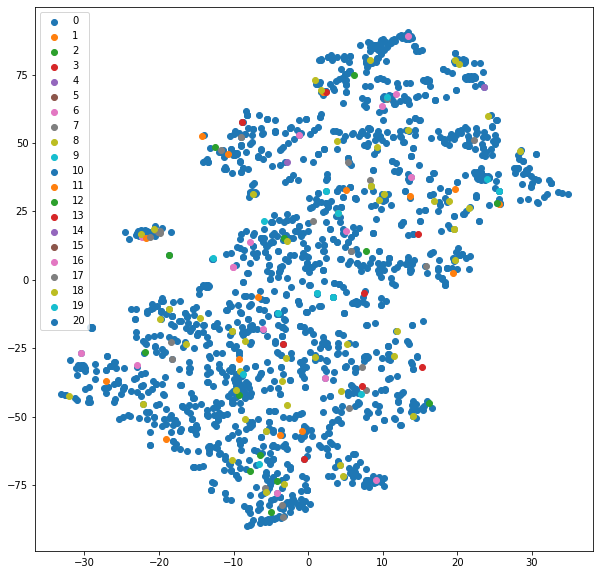

In [66]:
#Get the hidden layer representation after the first GCN layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([graph_node_features,A],batch_size=N)

#Get t-SNE Representation
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels,x_tsne):
    color_map = np.argmax(labels, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(len(labels[0])):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels,x_tsne)

In [88]:
[(idx, np.argmax(val)) for idx, val in enumerate(np.array(activations)[5]) if np.max(val)>0.2]

/localscratch/ipykernel_129320/1077312068.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  [(idx, np.argmax(val)) for idx, val in enumerate(np.array(activations)[5]) if np.max(val)>0.2]


[]